# Practicals: Backup Data Processing Plan, IRI Data Library
Code to download seasonal data from IRI data library and process into netcdf if data is not available on ftp site or locally



## Conda Install
This will require the following libraries to be installed in the conda environment, after checking they do not conflict with the int_desk train environment

Run the following commands in terminal:

conda activate intdesk_train

conda install -c conda-forge -c iri-nextgen cptdl cptio

## Libraries

In [2]:
import cptdl as dl 
import cptio as cio
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

In [3]:
#Directory Setup, pick your project folder
project_dir = '/Users/katie/Desktop/trial_pacisl' #setup directory where you want to work for this project

#make data directores if they don't exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'tsv_files'), exist_ok = True)
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
tsv_dir = os.path.join(data_dir, 'tsv_files')
nc_dir = os.path.join(data_dir, 'nc_files')

#sets up a month naming directory to calculate target months based on initialization month and lead times
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

## Download Setup from IRI Data Libraries

In [4]:
# Use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors.
# Make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands.
gcms = [ 'GEOSS2S.PRCP','SPEAR.PRCP', 'CCSM4.PRCP', 'CanSIPSIC3.PRCP', 'CFSv2.PRCP']
#predictand_name = 'UCSB0p05.PRCP' (UCSB0p05.PRCP is 5km data, UCSB.PRCP is 25' resolution data)
predictand_name = 'UCSB0p05.PRCP'

# 'fdate':
#   The initialization date of the model forecasts / hindcasts.
#   This field is defined by a python datetime.datetime object,
#   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
#   The year field is only used for forecasts, otherwise ignored.
#   The day field is only used in subseasonal forecasts, otherwise ignored.
#   The month field is an integer representing a month - ie, May=5.
forecast_dates_of_interest = [(2024,5,1), (2024,6,1)]

# lead_times will setup your target period of interest
# lead_low will be the start and lead_high will be the end
# for example, 1.5 and 3.5 for a forecast date of 2024,5,1 will be Jun-Aug
lead_times = {
'lead_low':[1.5,2.5,3.5],#1.5 month lead is the following month (e.g. for initialization in May, a forecast in June)
'lead_high':[3.5,4.5,5.5]
}

download_args = { 
    # 'first_year':
    #   The first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 1993.
    'first_year': 1993,  

    # 'final_year':
    #   The final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 2016.
    'final_year': 2016,  

    # 'predictor_extent':
    #   The geographic bounding box of the climate model data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictor_extent': {
        'east':  120,
        'west': 250, 
        'north': 10,
        'south': -30, 
      }, 

    # 'predictand_extent':
    #   The geographic bounding box of the observation data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictand_extent': {
        'east':  155,
        'west': 181,  
        'north': 3,  
        'south': -20, 
      },

    # 'filetype':
    #   The filetype to be downloaded. for now, it saves a lot of headache just to set this equal
    #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata.
    'filetype': 'cptv10.tsv'    
}

## Download Observational Data

In [ ]:
for f in forecast_dates_of_interest:
    initial_month = dt.datetime(*f).month
    obs_leads = []
    for l, lead_low in enumerate(lead_times['lead_low']):
        start_time = time.time()
        target_low = number_to_month_name_dictionary[initial_month + lead_low - 0.5]
        target_high = number_to_month_name_dictionary[initial_month + lead_times['lead_high'][l] - 0.5]
        l_download = download_args.copy()
        l_download['target'] = '-'.join([target_low, target_high])
        l_download['lead_low'] = lead_low
        l_download['lead_high'] = lead_times['lead_high'][l]
    
        obs_download_file = '_'.join([l_download['target'], str(lead_low), str(l_download['lead_high']), predictand_name])
        print(obs_download_file)

        print(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
        if not Path(os.path.join(nc_dir,'{}.nc'.format(obs_download_file))).is_file():
            print('STARTING DOWNLOAD OF {}'.format(obs_download_file))
            if not Path(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file))).is_file():
                Y = dl.download(dl.observations[predictand_name], os.path.join(tsv_dir,'{}.tsv'.format(obs_download_file)), **l_download, verbose=True, use_dlauth=False)
            else:
                Y = g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file)))
            Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[predictand_name]})
            Y = Y.sortby('X')
            Y.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
            print()
        else:
            Y = xr.open_dataset(os.path.join(nc_dir, '{}.nc'.format(obs_download_file)))
            Y = getattr(Y, [i for i in Y.data_vars][0])
        Y = Y.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        print('download time is ' + str(time.time() - start_time))
        obs_leads.append(Y)
    obs_leads = xr.concat(obs_leads, dim = 'L')
    splot = obs_leads.isel(L=0).swap_dims({'S':'T'}).plot(col = 'T', col_wrap = 5, subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)})
    for ax in  splot.axs.flat:
        coasts = ax.coastlines()
        ax.set_xlim(download_args['predictand_extent']['east'], download_args['predictand_extent']['west'])
        ax.set_ylim(download_args['predictand_extent']['south'], download_args['predictand_extent']['north'])
    plt.show()

Jun-Aug_1.5_3.5_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Jun-Aug_1.5_3.5_UCSB0p05.PRCP.nc
STARTING DOWNLOAD OF Jun-Aug_1.5_3.5_UCSB0p05.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p05/.prcp/92/mul/T/(1%20Jan%201993)/(31%20Dec%202016)/RANGE/T/%28Jun-Aug%201993-2016%29/seasonalAverage/Y/%28-20%29/%283%29/RANGEEDGES/X/%28181%29/%28155%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv



## Download Model Data, Including Hindcasts and Forecasts

(2024, 5, 1)
one month initialization


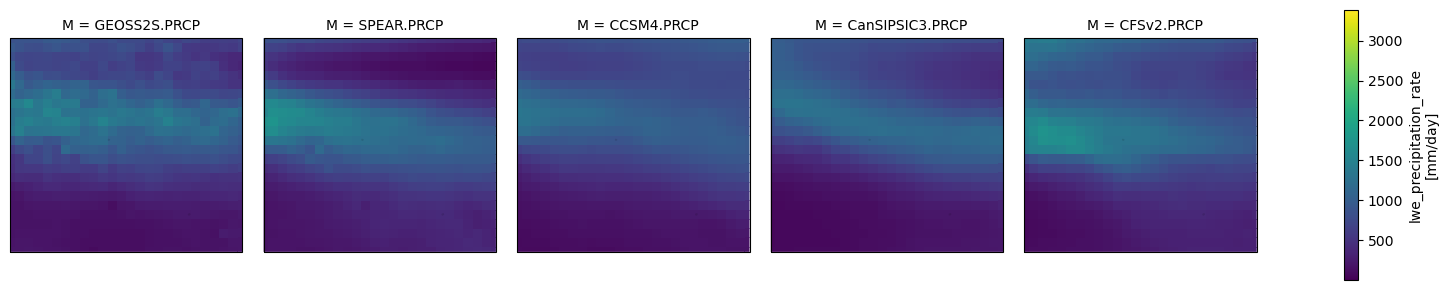

(2024, 6, 1)
one month initialization


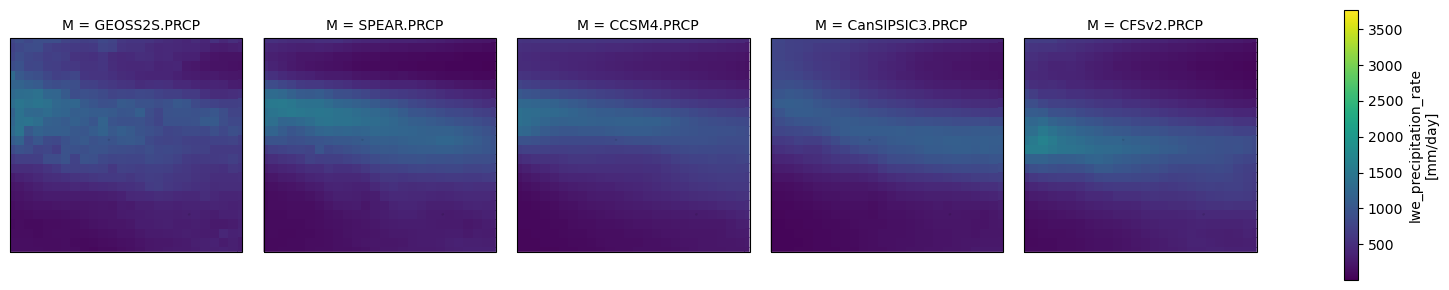

In [43]:
# Download GCMs and save raw models to netcdf
for f in forecast_dates_of_interest:
    print(f)
    iyear, imonth, iday = f # Create the datetime object for initialized data from f (stored as a tuple)
    fdate = dt.datetime(iyear, imonth, iday)
    initial_month = dt.datetime(*f).month
    hindcast_data, forecast_data = [], []
    for l, lead_low in enumerate(lead_times['lead_low']):
        target_low = number_to_month_name_dictionary[initial_month + lead_low - 0.5]
        target_high = number_to_month_name_dictionary[initial_month + lead_times['lead_high'][l] - 0.5]
        l_download = download_args.copy()
        l_download['target'] = '-'.join([target_low, target_high])
        l_download['lead_low'] = lead_low
        l_download['lead_high'] = lead_times['lead_high'][l]
        l_download['fdate'] = fdate
        hindcast_data_l, forecast_data_l = [], []
        for gcm in gcms:
            gcm_hindcast_download_file = '_'.join([l_download['target'], str(lead_low), str(l_download['lead_high']), 'raw_hind', gcm])
            gcm_forecast_download_file = '_'.join([l_download['target'], str(lead_low), str(l_download['lead_high']), 'raw_fcst', gcm])
            if not Path(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).is_file():
                if not Path(os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file))).is_file():
                    print('STARTING DOWNLOAD OF {}'.format(gcm_hindcast_download_file))
                    g = dl.download(dl.hindcasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_hindcast_download_file)), **l_download, verbose=True, use_dlauth=False)
                    f = dl.download(dl.forecasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file)), **l_download, verbose=True, use_dlauth=False)
                    g = getattr(g, [i for i in g.data_vars][0])
                    f = getattr(f, [i for i in f.data_vars][0])
                    print()
                else:
                    print('LOADING {} FROM FILE'.format(gcm_hindcast_download_file))
                    g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_hindcast_download_file)))
                    f = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_forecast_download_file)))
                    print()
                    g = getattr(g, [i for i in g.data_vars][0])
                    f = getattr(f, [i for i in f.data_vars][0])
                #label datasets by model name
                g = g.expand_dims({'M':[gcm]})
                f = f.expand_dims({'M':[gcm]})

                #regrid models to observation coordinates for consistent grids across models
                #g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
                #f = xc.regrid(f, Y.coords['X'].values, Y.coords['Y'].values)

                nc_prep = xr.concat(g, 'M')
                nc_prep.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file)))
                f_nc_prep = xr.concat(f, 'M')
                f_nc_prep.to_netcdf(os.path.join(nc_dir, '{}.nc'.format(gcm_forecast_download_file)))
            else:
                g = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file))).prec
                f = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).prec
            hindcast_data_l.append(g)
            forecast_data_l.append(f)
        hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
        forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
        hindcast_data_l = hindcast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        forecast_data_l = forecast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        hindcast_data.append(hindcast_data_l)
        forecast_data.append(forecast_data_l)
    hindcast_data = xr.concat(hindcast_data, dim = 'L')
    forecast_data = xr.concat(forecast_data, dim = 'L')
    
    print('one month initialization')
    splot = hindcast_data.isel(L = 0).swap_dims({'S':'T'}).isel(T=0).plot(col = 'M', col_wrap = 5, subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)})
    for ax in  splot.axs.flat:
        ax.set_xlim(download_args['predictand_extent']['east'], download_args['predictand_extent']['west'])
        ax.set_ylim(download_args['predictand_extent']['south'], download_args['predictand_extent']['north'])
        ax.coastlines("10m", alpha=0.1, zorder=3)
    plt.show()